In [436]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [437]:
feature_class = pd.read_csv('feature_class.csv')
train_df, test_df = train_test_split(feature_class, test_size=0.2, random_state=42) 

In [438]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(25, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out


In [439]:
input_size = 15  
num_classes = 6  

model = SimpleNN(input_size, num_classes)
loss = nn.CrossEntropyLoss()
optimize = optim.Adam(model.parameters(), lr=0.001)

In [440]:
feature_torch = torch.tensor(train_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch = torch.tensor(train_df['label'].values,dtype=torch.int64)

feature_torch_test = torch.tensor(test_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch_test = torch.tensor(test_df['label'].values,dtype=torch.int64)


In [441]:
train_dataset = TensorDataset(feature_torch, label_torch)
test_dataset = TensorDataset(feature_torch_test, label_torch_test)

In [442]:
batch_size = 12

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [443]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [444]:
def validate():

    model.eval()
    correct = 0
    total = 0
    for features, labels in test_loader: 
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total
    

In [445]:
# train the model

epochs = 400
running_loss = 0

# store the loss and accuracy
training_loss_list = []
valid_acc_list = []

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)

        optimize.zero_grad()
        outputs = model.forward(features)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimize.step()
        running_loss += loss_value.item()
        labels_correct = torch.argmax(outputs, dim=1) == labels
        
       

    valid_acc = validate()
    print(f'Epoch: {epoch+1}/{epochs}..',
        f'Training Loss: {running_loss/len(test_loader):.3f}',
        f'Training Accuracy: {100*len(labels_correct)/len(labels):.3f}%',
        f'Validation Accuracy: {valid_acc:.3f}%')
    
    training_loss_list.append(running_loss/len(test_loader))
    valid_acc_list.append(valid_acc)
    
    running_loss = 0.0

Epoch: 1/400.. Training Loss: 7.257 Training Accuracy: 100.000% Validation Accuracy: 31.095%
Epoch: 2/400.. Training Loss: 6.818 Training Accuracy: 100.000% Validation Accuracy: 31.095%
Epoch: 3/400.. Training Loss: 6.819 Training Accuracy: 100.000% Validation Accuracy: 31.095%
Epoch: 4/400.. Training Loss: 6.821 Training Accuracy: 100.000% Validation Accuracy: 31.095%
Epoch: 5/400.. Training Loss: 6.767 Training Accuracy: 100.000% Validation Accuracy: 33.582%
Epoch: 6/400.. Training Loss: 6.581 Training Accuracy: 100.000% Validation Accuracy: 37.562%
Epoch: 7/400.. Training Loss: 6.565 Training Accuracy: 100.000% Validation Accuracy: 37.313%
Epoch: 8/400.. Training Loss: 6.443 Training Accuracy: 100.000% Validation Accuracy: 45.522%
Epoch: 9/400.. Training Loss: 6.280 Training Accuracy: 100.000% Validation Accuracy: 45.025%
Epoch: 10/400.. Training Loss: 6.260 Training Accuracy: 100.000% Validation Accuracy: 45.274%
Epoch: 11/400.. Training Loss: 6.004 Training Accuracy: 100.000% Vali

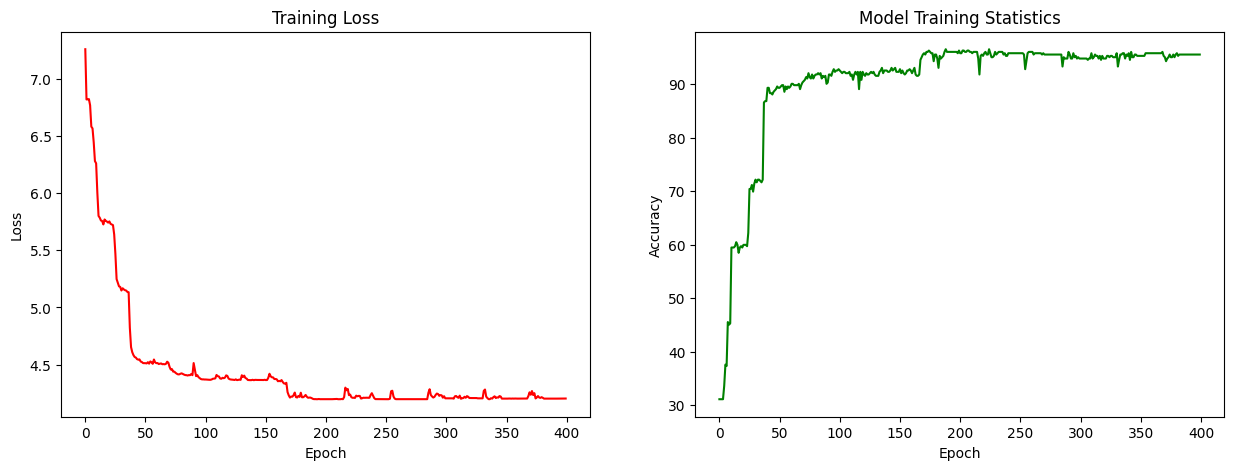

In [446]:
# plot the training loss and validation accuracy in seperate plots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(training_loss_list, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(valid_acc_list, color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.title('Model Training Statistics')
plt.show()